# Word Embeddings

![](../figs/intro_nlp/embeddings/embeddings.png)

## What are word embeddings?

Word embeddings are a way of representing words as vectors. The vectors are learned from text data and are able to capture some of the semantic and systactic information of the words. 

For example, the word `cat` is similar to `dog` from the following sentences:

"The cat is lying on the floor and the dog was eating”,
 
"The doc was lying on the floor and the cat was eating”

In a mathematical sense, a word embedding is a parameterized function of the word:

$$ f_{\theta}(w) = \theta $$

where $\theta$ is a vector of real numbers. The vector $\theta$ is the embedding of the word $w$.

In a broad sense, `embedding` refers to a lower-dimensional dense vector representation of a higher-dimensional object.
  - in NLP, this higher-dimensional object will be a document.
  - in computer vision, this higher-dimensional object will be an image.

Examples of embeddings and non-embeddings:

  - **Non-embeddings**:
    - one-hot encoding, bag-of-words, TF-IDF, etc.
    - counts over LIWC dictionary categories.
    - sklearn CountVectorizer count vectors
  - **Embeddings**:
    - word2vec, GloVe, BERT, ELMo, etc.
    - PCA reductions of the word count vectors
    - LDA topic shares
    - compressed encodings from an autoencoder



## Categorical Embeddings

![](../figs/intro_nlp/embeddings/1.png)

Categorical embeddings are a way of representing categorical variables as vectors.

For a binary classification problem with outcome $Y$:
- If you have a high-dimensional categorical variable $X$, (e.g. 1000 categories), you can represent $X$ as a vector of length 1000.
- It is computationally expensive for a ML model to learn from a high-dimensional categorical variable.

Instead, you can represent $X$ as a lower-dimensional vector of length $k$ (e.g. 10). This is called a categorical embedding. 

Embedding approaches:

1. PCA applied to the dummy variables $X$ to get a lower-dimensional vector representation of $\tilde{X}$.
2. Regress $Y$ on $X$, predict $\hat{Y}(X_i)$, use that as a feature in a new model.



### An embedding layer is matrix multiplication:

$$
\underbrace{h_1}_{n_E \times 1} = \underbrace{\omega_E}_{n_E \times n_W} \cdot \underbrace{x}_{n_x \times 1} 
$$

- $x$ = a categorical variable (e.g., representing a word)
  - One-hot vector with a single item equaling one.
  - Input to the embedding layer.
- $h_1$ = the first hidden layer of the neural net
  - The output of the embedding layer.
- The embedding matrix $\omega_E$ encodes predictive information about the categories.
- It has a spatial interpretation when projected into 2D space.
  - Each row of $\omega_E$ is a vector in $n_E$-dimensional space.
  - The rows of $\omega_E$ are the coordinates of the points in the vector space.
  - The points are the categories.
  - The distance between the points is the similarity between the categories.
  - The angle between the points is the relationship between the categories.

### Embedding Layers versus Dense Layers

An embedding layer is statistically equivalent to a fully-connected dense layer with one-hot vectors as input and linear activation.

- Embedding layers are much faster for many categories (>~50)

## Word Embeddings

> Word embeddings are neural network layers that map words to dense vectors.


Documents are lists of word indexes ${w_1 ,w_2 ,...,w_{n_i} }$.

- Let $w_i$ be a one-hot vector (dimensionality $n_w$ = vocab size) where the associated word’s index equals one.
- Normalize all documents to the same length L; shorter documents can be padded with a null token.
- This requirement can be relaxed with recurrent neural networks.

The embedding layer replaces the list of sparse one-hot vectors with a list of n E -dimensional ($n_E$ << $n_w$ ) dense vectors

$$ \mathbf{X} = [x_1 \ldots x_L ] $$

where

$$
\underbrace{x_j}_{n_E \times 1} = \underbrace{\mathbf{E}}_{n_E \times n_W} \cdot \underbrace{w_j}_{n_w \times 1}
$$

$\mathbf{E}$ a matrix of word vectors. The column associated with the word at $j$ is selected by the dot-product with one-hot vector $w_j$.

$\mathbf{X}$ is flattened into an $L * n_E$ vector for input to the next layer.


![](../figs/intro_nlp/embeddings/4.png)


### Why do we need neural networks for word embeddings?

There are a lot of shallow algorithms that work well for clustering.
- k-means
- hierarchical clustering
- spectral clustering
- PCA

The reasons we use neural networks for word embeddings are:
- They are able to learn the relationships between words.
- They can be used as input to a downstream task.
- They create a mapping of discrete words to continuous vectors.
- They solve the curse of dimensionality.

## Neural Language Models

Word embeddings were proposed by {cite}`bengio2003neural` as a way to represent words as vectors.

Bengio’s method could train a neural network such that each training sentence could inform the model about a number of semantically available neighboring words, which was known as `distributed representation of words`. The nueural network preserved relationships between words in terms of their contexts (semantic and syntactic).

![](../figs/intro_nlp/embeddings/bengio.png)


This introduced a neural network architecture approach that laid the foundation for many current approaches. 

This neural network has three components:
- **Embedding layer**: maps words to vectors, the parameters are shared across the network.
- **Hidden layer**: a fully connected layer with a non-linear activation function.
- **Output layer**: produces a probability distribution over the vocabulary using a softmax function.

In [67]:
sentences = ["i like apples", "i like bananas", "i hate oranges"]

### Step 1: Indexing the words. 

For each word in the sentence, we assign an index.


In [68]:
words = " ".join(sentences).split()
word_list = list(set(words))
word_to_id = {w: i for i, w in enumerate(word_list)}
id_to_word = {i: w for w, i in word_to_id.items()}
vocab_size = len(word_to_id)
print("vocab_size:", vocab_size)

vocab_size: 6


### Step 2: Building the model.

- An embedding layer is a lookup table that maps each word to a vector.
- Once the input index of the word is embedded, it is passed through the first hidden layer with bias added to it.
- The output of the first hidden layer is passed through a tanh activation function.
- The output from the embedding layer is also passed through the final layer where the output of the tanh layer is added to it.


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim


class NNLM(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_hiddens, num_steps):
        self.num_steps = num_steps
        self.embedding_size = embedding_size

        super(NNLM, self).__init__()
        self.embeddings = nn.Embedding(
            vocab_size, embedding_size
        )  # embedding layer or look up table

        self.hidden1 = nn.Linear(num_steps * embedding_size, num_hiddens, bias=False)
        self.ones = nn.Parameter(torch.ones(num_hiddens))

        self.hidden2 = nn.Linear(num_hiddens, vocab_size, bias=False)
        self.hidden3 = nn.Linear(
            num_steps * embedding_size, vocab_size, bias=False
        )  # final layer

        self.bias = nn.Parameter(torch.ones(vocab_size))

    def forward(self, X):
        word_embeds = self.embeddings(X)  # embeddings
        X = word_embeds.view(-1, self.num_steps * self.embedding_size)  # first layer
        tanh = torch.tanh(self.ones + self.hidden1(X))  # tanh layer
        output = (
            self.bias + self.hidden3(X) + self.hidden2(tanh)
        )  # summing up all the layers with bias
        return word_embeds, output

### Step 3: Loss and optimization function.

Now that we have the model, we need to define the loss function and the optimization function.

We are using the cross-entropy loss function and the Adam optimizer.

The cross-entropy loss function is made up of two parts:
- The softmax function: this is used to normalize the output of the model so that the sum of the probabilities of all the words in the vocabulary is equal to one.
- The negative log-likelihood: this is used to calculate the loss.


In [70]:
num_steps = 2
num_hiddens = 2
embedding_size = 2

model = NNLM(vocab_size, embedding_size, num_hiddens, num_steps)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Step 4: Training the model.

Finally, we train the model.


In [71]:
def make_batch(sentences, word_to_id):
    input_batch = []
    target_batch = []

    for sent in sentences:
        word = sent.split()
        input = [word_to_id[n] for n in word[:-1]]
        target = word_to_id[word[-1]]


        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch

In [72]:
input_batch, target_batch = make_batch(sentences, word_to_id)
input_batch = torch.LongTensor(input_batch)
target_batch = torch.LongTensor(target_batch)


for epoch in range(5000):
    optimizer.zero_grad()
    embeddings, output = model(input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.6f}".format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.488254
Epoch: 2000 cost = 0.466801
Epoch: 3000 cost = 0.463683
Epoch: 4000 cost = 0.462811
Epoch: 5000 cost = 0.462459


In [73]:
# Test
predict = model(input_batch)[1].data.max(1, keepdim=True)[1]

print(
    [sen.split()[:2] for sen in sentences],
    "->",
    [id_to_word[n.item()] for n in predict.squeeze()],
)

[['i', 'like'], ['i', 'like'], ['i', 'hate']] -> ['bananas', 'bananas', 'oranges']


### Summary

- Word embeddings are a way to represent words as low-dimensional dense vectors.
- These embeddings have associated learnable vectors, which optimize themselves through back propagation. 
- Essentially, the embedding layer is the first layer of a neural network.
- They try to preserve the semantic and syntactic relationships between words.

![](../figs/intro_nlp/embeddings/w2v.png)


## Word2Vec

Word2Vec is a neural network architecture that was proposed by {cite}`mikolov2013distributed` in 2013. It is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of words.

The problem of the previous neural network is that it is computationally expensive to train. The hidden layer computes probability distribution for all the words in the vocabulary. This is because the output layer is a fully connected layer.

Word2Vec solves this problem by using a single output neuron. This is achieved by using a `hierarchical softmax` or `negative sampling` method.

### Main idea

- Use a `binary classifier` to predict which words appear in the context of (i.e. near) a target word.
- The `parameters of that classifier` provide a dense vector representation of the target word (embedding).
- Words that appear in similar contexts (that have high distributional similarity) will have very similar vector representations.
- These models can be trained on large amounts of raw text (and pre-trained embeddings can be downloaded).

### Negative sampling

Train a binary classifier that decides whether a target word t appears in the context of other words $c_{1..k}$

- `Context`: the set of k words near (surrounding) t
- Treat the target word t and any word that actually appears in its context in a real corpus as `positive` examples
- Treat the target word t and randomly sampled words that don’t appear in its context as `negative` examples
- Train a `binary logistic regression` classifier to distinguish these cases
- The `weights` of this classifier depend on the `similarity` of t and the words in $c_{1..k}$


### Two models

- **Continuous Bag of Words (CBOW)**: predicts the target word from the context words.
- **Skip-gram**: predicts the context words from the target word.

![](../figs/intro_nlp/embeddings/cbow_skip-gram.png)


### When to use the skip-gram model and when to use CBOW?

- CBOW is faster to train than skip-gram.
- Skip-gram is better at capturing rare words and their contexts.
- CBOW is better at capturing common words and their contexts.
- Skip-gram works better with small datasets.
- Therefore, the choice of model depends on the kind of problem you are trying to solve.

## Skip-gram model

The skip-gram model is the same as the CBOW model with one difference: it predicts the context words from the target word.

In the above figure, $w[t]$ is the target word, and $w[t-2], w[t-1], w[t+1], w[t+2]$ are the context words, where $t$ is the location of the target word in the sentence.

The model predicts the probability of a word being a context word given the target word. The output probabilities explain how likely a word is to be close to the target word.

This shallow neural network architecture is called a `skip-gram` model because it predicts the context words from the target word.

We don't use this trained network for prediction. Instead, we use the weights of the embedding layer as the word embeddings.

### Input/output/hidden layer

How do we represent a single target word as a large vector?

- We can use a one-hot vector to represent the target word.
- Say we have a vocabulary of 10,000 words. Then the one-hot vector for the word “deep” will be a vector of 10,000 elements, where all the elements are 0 except the 4th element, which is 1.
- Similarly, the output layer will be a vector of 10,000 elements, where each element represents the probability of the word being the context word.
- The hidden layer is a linear layer that maps the one-hot vector to a vector of $d$ elements, where $d$ is the dimension of the word embeddings.
- The opimized weights of the hidden layer are the word embeddings.
- The dimensions of the hidden layer are $d \times V$, where $V$ is the size of the vocabulary.

![](../figs/intro_nlp/embeddings/skip-gram.png)


### Step 0: Prepare the data

In [36]:
%config InlineBackend.figure_format='retina'

from ekorpkit import eKonf

cfg = eKonf.compose('path')
cfg.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/us_equities_news_sampled.zip'
corpus = eKonf.load_data("us_equities_news_sampled.parquet", cfg.cached_path)
sentences = corpus.text[2].lower().split("\n")
words = " ".join(sentences).split()
sentences

['chip name micron technology inc nasdaq mu is higher on two new price target hikes from analysts specifically bmo lifted its price target to 60 from 50 while cowen boosted its estimate to 46 from 38 these two bull notes come just one day before mu s fiscal fourth quarter earnings report due out after the close tomorrow sept 26',
 'this puts the consensus micron nasdaq mu 12 month target price at 51 59 which sits just atop the stock s sept 11 of 51 39 and represents a 7 premium to mu s current perch at 49 22 up 1 5 on the day meanwhile 14 brokerages in coverage call the equity a buy or better and 10 say it s a hold or worse',
 'it s no surprise that most analysts are optimistic ahead of mu s quarterly reveal the semiconductor name tends to do quite well the day after earnings in fact only three of its last eight post earnings moves were negative and the equity managed a 13 3 next day pop on in june this time around the options market is pricing in an 11 4 swing for friday s trading reg

### Step 1: Setting target and context variable

Since skipgram takes a single context word and n number of target variables, we just need to flip the CBOW from the previous model.

when the window size is 1, we take one word before and after the target word.

For example, if we have the sentence “I like deep learning because it is fun”, and the window size is 1, the function will return the following list:

```python
[['like', 'I'],
 ['like', 'deep'],
 ['deep', 'like'],
 ['deep', 'learning'],
 ['learning', 'deep'],
 ['learning', 'because'],
 ...
]
```

In [6]:
def skipgram(words, window_size=1):
    skip_grams = []
    for i in range(window_size, len(words) - window_size):
        target = words[i]
        context = [words[i - window_size], words[i + window_size]]
        for w in context:
            skip_grams.append([target, w])

    return skip_grams

In [7]:
skipgram("I like deep learning because it is fun".split(), 1)

[['like', 'I'],
 ['like', 'deep'],
 ['deep', 'like'],
 ['deep', 'learning'],
 ['learning', 'deep'],
 ['learning', 'because'],
 ['because', 'learning'],
 ['because', 'it'],
 ['it', 'because'],
 ['it', 'is'],
 ['is', 'it'],
 ['is', 'fun']]

### Step 2: Building the model

In [12]:
import torch
import torch.nn as nn


class skipgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, word_to_ix):
        super(skipgramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.W = nn.Linear(embedding_size, embedding_size, bias=False)
        self.WT = nn.Linear(embedding_size, vocab_size, bias=False)
        self.word_to_ix = word_to_ix

    def forward(self, X):
        embeddings = self.embedding(X)
        hidden_layer = nn.functional.relu(self.W(embeddings))
        output_layer = self.WT(hidden_layer)
        return output_layer

    def get_word_emdedding(self, word):
        word = torch.tensor([self.word_to_ix[word]])
        return self.embedding(word).view(1, -1)

### Step 3: Loss and optimization function

In [16]:
import torch.optim as optim

word_list = list(set(words))
word_to_id = {w: i for i, w in enumerate(word_list)}
id_to_word = {i: w for w, i in word_to_id.items()}
vocab_size = len(word_list)
print("vocab_size:", vocab_size)

batch_size = 2  # mini-batch size
embedding_size = 5  # embedding size

model = skipgramModel(vocab_size, embedding_size, word_to_id)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

vocab_size: 222


### Step 4: Training the model

In [17]:
import numpy as np
from tqdm.auto import tqdm


def words_to_vector(words, word_to_ix):
    idxs = [word_to_ix[w] for w in words]
    return torch.tensor(idxs, dtype=torch.long)


def random_batch(skip_grams, batch_size=2):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(skip_grams[i][0])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels


for epoch in tqdm(range(150000), total=len(skipgram(words))):
    input_batch, target_batch = random_batch(skipgram(words), batch_size)
    input_batch = torch.LongTensor(words_to_vector(input_batch, word_to_id))
    target_batch = torch.LongTensor(words_to_vector(target_batch, word_to_id))

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 10000 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.6f}".format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

  0%|          | 0/716 [00:00<?, ?it/s]

Epoch: 10000 cost = 3.896727
Epoch: 20000 cost = 2.242064
Epoch: 30000 cost = 3.617461
Epoch: 40000 cost = 4.317378
Epoch: 50000 cost = 2.380702
Epoch: 60000 cost = 4.073981
Epoch: 70000 cost = 3.560866
Epoch: 80000 cost = 4.322421
Epoch: 90000 cost = 2.438971
Epoch: 100000 cost = 4.790970
Epoch: 110000 cost = 4.703344
Epoch: 120000 cost = 2.545708
Epoch: 130000 cost = 2.590156
Epoch: 140000 cost = 2.531536
Epoch: 150000 cost = 2.791655


### Visualizing the embeddings

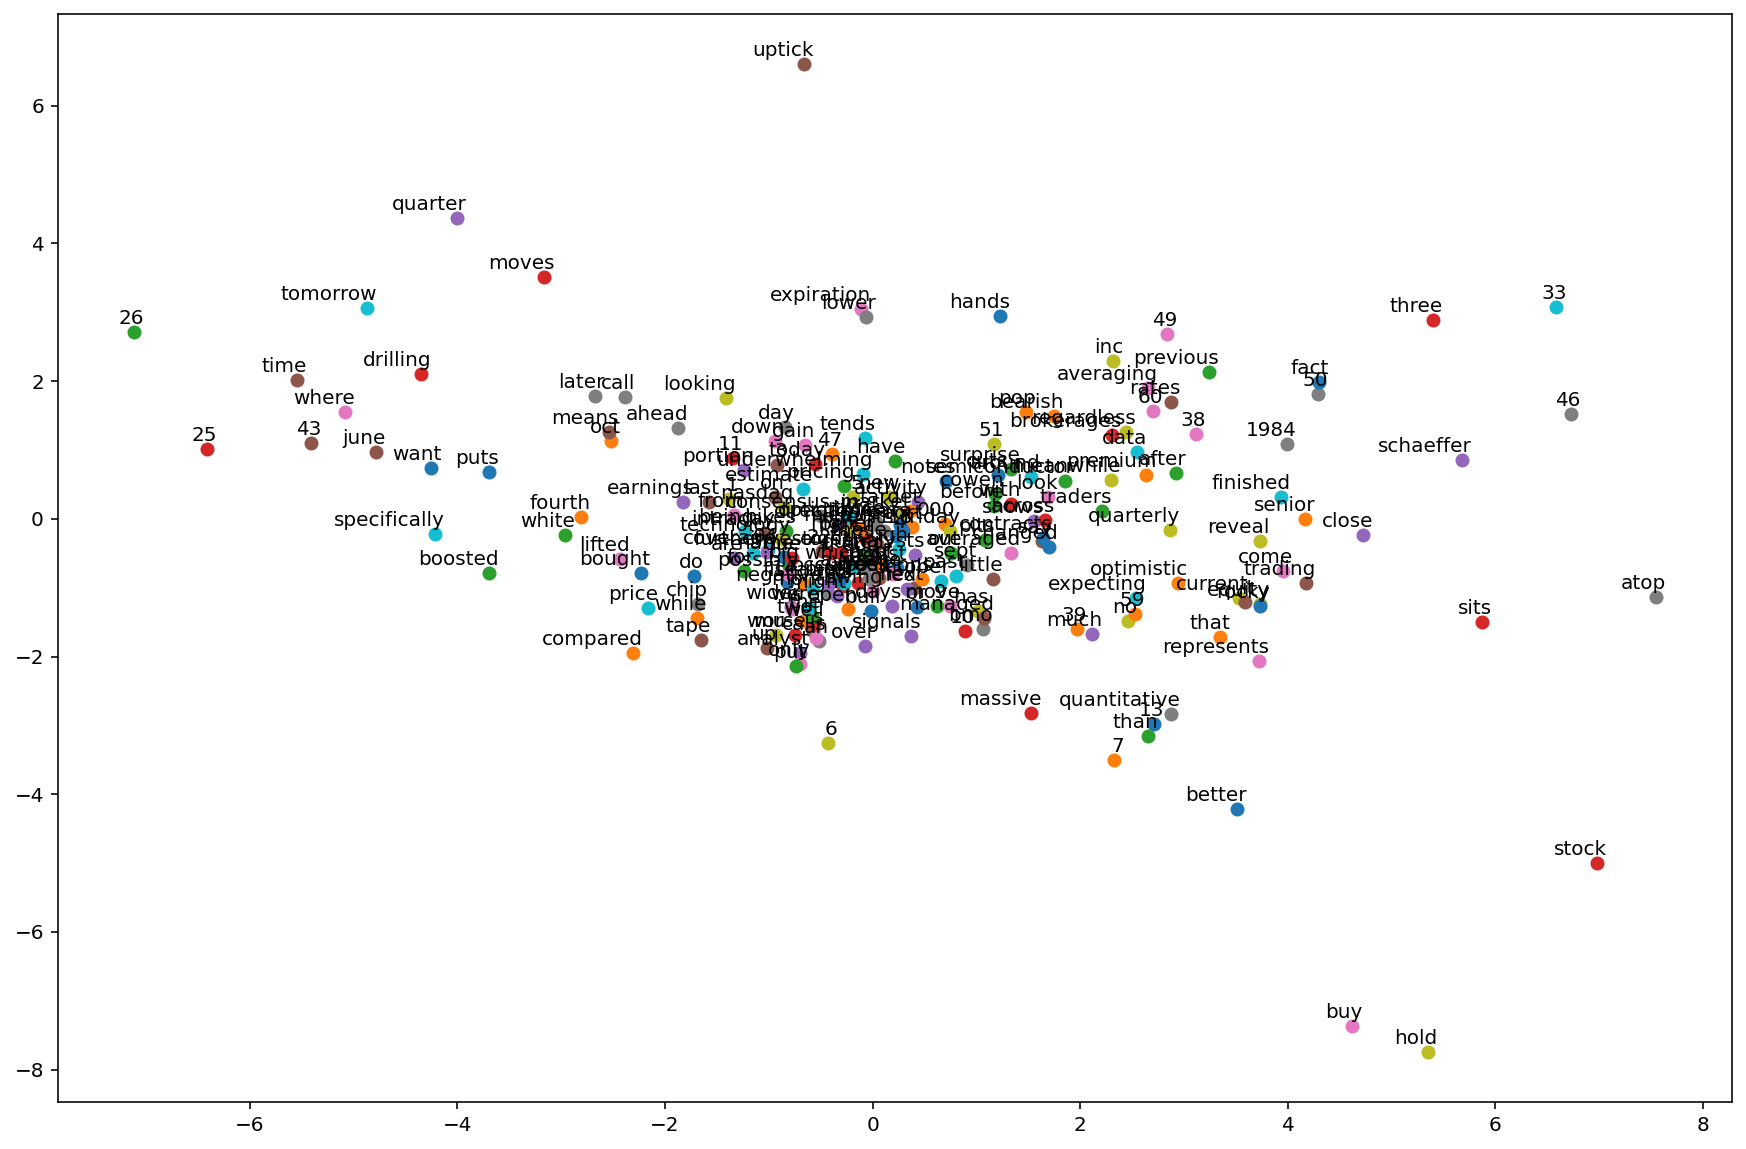

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 10))

for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(
        w, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
    )
plt.show()

### Evaluation

In [19]:
def skipgram_test(test_data, model):
    correct_ct = 0

    for i in range(len(test_data)):
        input_batch, target_batch = random_batch(test_data, batch_size)
        input_batch = torch.LongTensor(words_to_vector(input_batch, word_to_id))
        target_batch = torch.LongTensor(words_to_vector(target_batch, word_to_id))

        model.zero_grad()
        _, predicted = torch.max(model(input_batch), 1)

        if predicted[0] == target_batch[0]:
            correct_ct += 1

    print(
        "Accuracy: {:.1f}% ({:d}/{:d})".format(
            correct_ct / len(test_data) * 100, correct_ct, len(test_data)
        )
    )

In [20]:
skipgram_test(skipgram(words), model)

Accuracy: 13.0% (93/716)


In [22]:
pred = ["earnings"]

model_pred = []
e = 0
model_pred.append(pred[0])

while e < 6:
    word = id_to_word[
        torch.argmax(model(torch.LongTensor([word_to_id[model_pred[-1]]]))).item()
    ]
    model_pred.append(word)
    e += 1

" ".join(model_pred)

'earnings quarter fourth october 9 and senior'

The skip-gram model increases computational complexity because it has to predict nearby words based on the number of neighboring words. The more distant words tend to be slightly less related to the current word.

## Continuous Bag of Words (CBOW)

The CBOW model predicts the target word from the context words.

This model reduces the complexity of calculating the probability distribution for all the words in the vocabulary to the $\log_2(V)$ complexity of calculating the probability distribution for the target word.

![](../figs/intro_nlp/embeddings/cbow_skip-gram.png)


### Architecture

```{image} ../figs/intro_nlp/embeddings/cbow.png
:alt: cbow
:class: bg-primary mb-1
:width: 350px
:align: center
```

- The input layer is the context words.
- The input is $C$ context words, each represented as a one-hot vector of size $V$, where $V$ is the size of the vocabulary, yielding a $C \times V$ matrix.
- Each row of the matrix is multiplied by the weight matrix $W$ of size $V \times N$, where $N$ is the size of the embedding.
- The resulting matrix is summed up to get a vector of size $N$.
- This vector is passed through a softmax layer to get the probability distribution of the target word.
- The learned weights of the softmax layer are the word embeddings.

### Step 1: Define a function to create a context and a target word

Define a function to create a context window with n words from the right and left of the target word.

The function should take two arguments: data and window size. The window size will define how many words we are supposed to take from the right and from the left. 

The for loop: `for i in range(window_size, len(words) – window_size)`: iterates through a range starting from the window size, i.e. 2 means it will ignore words in index 0 and 1 from the sentence, and end 2 words before the sentence ends. 

Inside the for loop, we try separate context and target words and store them in a list.

For example, if we have the sentence “I like deep learning because it is fun”, and the window size is 2, the function will return the following list:

```python
[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]
```

In [37]:
def CBOW(words, window_size=2):
    data = []
    for i in range(window_size, len(words) - window_size):
        context = [
            words[i - window_size],
            words[i - (window_size - 1)],
            words[i + (window_size - 1)],
            words[i + window_size],
        ]
        target = words[i]
        data.append((context, target))

    return data

Let’s call the function and see the output. 

In [38]:
CBOW("I like deep learning because it is fun".split())

[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]

### Step 2: Build the model

In the CBOW model, we reduce the hidden layer to only one. So all together we have: an embedding layer, a hidden layer which passes through the ReLU layer, and an output layer.

The context words index is fed into the embedding layers, which is then passed through the hidden layer followed by the nonlinear activation layer, i.e. ReLU, and finally we get the output.

In [39]:
import torch
import torch.nn as nn


class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, word_to_ix):
        super(CBOW_Model, self).__init__()
        self.word_to_ix = word_to_ix

        # out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([self.word_to_ix[word]])
        return self.embeddings(word).view(1, -1)

### Step 3: Loss and optimization function. 

We are using the cross-entropy loss function and the SGD optimizer. You can also use the Adam optimizer.

In [41]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

# By deriving a set from `words`, we deduplicate the array
vocab = set(words)
vocab_size = len(vocab)
print("vocab_size:", vocab_size)

word_list = list(vocab)

word_to_id = {word: ix for ix, word in enumerate(vocab)}
id_to_word = {ix: word for ix, word in enumerate(vocab)}

data = CBOW(words)
model = CBOW_Model(vocab_size, EMDEDDING_DIM, word_to_id)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

vocab_size: 222


### Step 4: Training the model.

Finally, we train the model.

`words_to_vector` turns words into numbers. 


In [47]:
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = words_to_vector(context, word_to_id)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_id[target]]))

    # optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss.item()}")

Epoch: 9, Loss: 7.895180702209473
Epoch: 19, Loss: 6.261657238006592
Epoch: 29, Loss: 5.2918782234191895
Epoch: 39, Loss: 4.626347541809082
Epoch: 49, Loss: 4.151697635650635


### Visualizing the embeddings

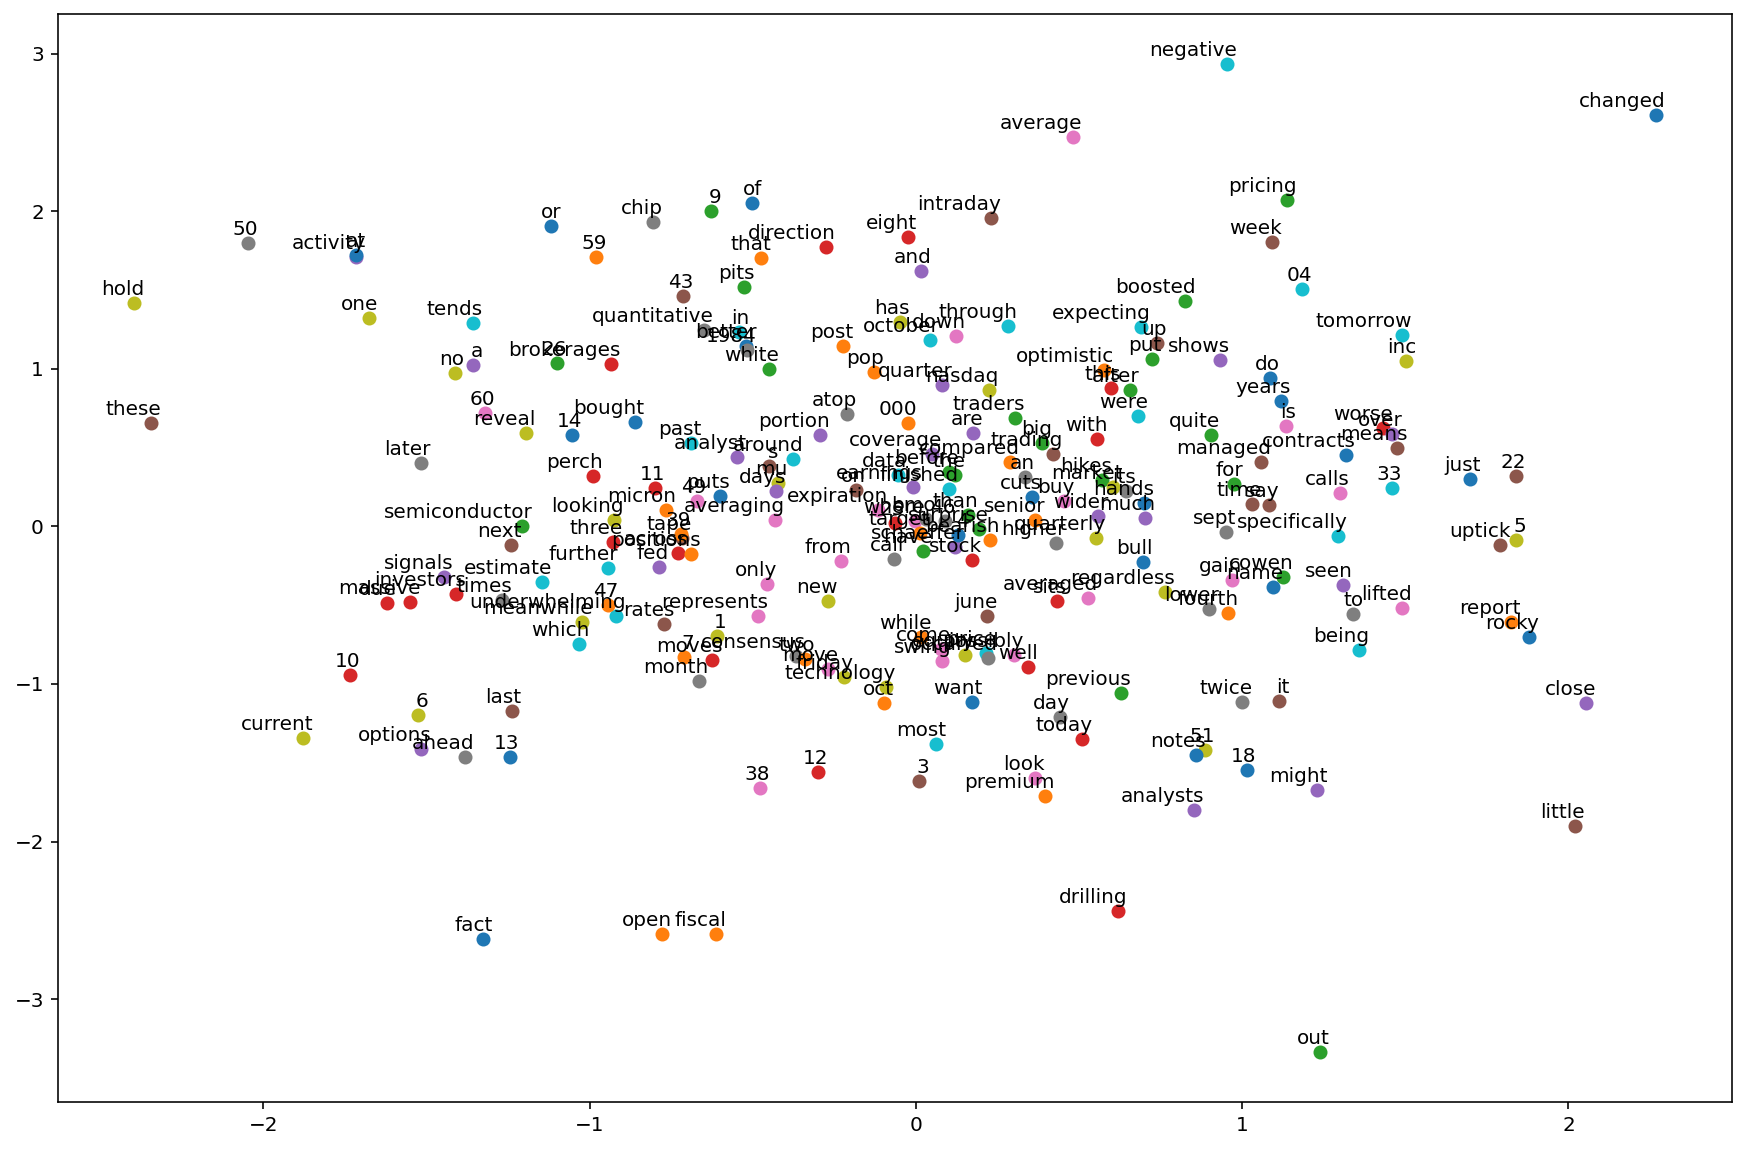

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(
        w, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
    )
plt.show()

### Evaluation

In [49]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = words_to_vector(context, word_to_id)
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_id[target]]):
            correct_ct += 1

    print(
        "Accuracy: {:.1f}% ({:d}/{:d})".format(
            correct_ct / len(test_data) * 100, correct_ct, len(test_data)
        )
    )

In [50]:
CBOW_test(data, model)

Accuracy: 99.7% (355/356)


In [51]:
context = ["chip", "name", "technology", "inc"]
context_vector = words_to_vector(context, word_to_id)
a = model(context_vector)

In [52]:
print(f"Context: {context}\n")
print(f"Prediction: {id_to_word[torch.argmax(a[0]).item()]}")

Context: ['chip', 'name', 'technology', 'inc']

Prediction: micron


## Improving predictive functions


### Softmax

The equation for the softmax function is:

$$
\begin{align}
\text{softmax}(x_i|c) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
\end{align}
$$

where $x_i$ is the score of the target word $w_i$ and $c$ is the context words.

The complexity of the softmax function is $\mathcal{O}(n)$, where $n$ is the number of words in the vocabulary.

With a large vocabulary, say 100,000 words, the softmax function becomes very expensive to compute. For each word ($w_i$), we have to compute the exponential of the score of each word in the vocabulary ($x_j$) and then sum them up. This is $\mathcal{O}(n)$.

### Hierarchical softmax

Hierarchical softmax is a method to reduce the complexity of the softmax function. It is a tree-based data structure that is used to represent the vocabulary.

Hierarchical softmax was introduced by Morin and Bengio in 2005, as an alternative to the full softmax function, where it replaces it with a hierarchical layer. It borrows the technique from the binary huffman tree, which reduces the complexity of calculating the probability from $\mathcal{O}(n)$ to $\mathcal{O}(\log_2(n))$.

The hierarchical softmax is a binary tree, where each node represents a word in the vocabulary. The root node represents the entire vocabulary. The left child represents the words that are less frequent than the parent node, and the right child represents the words that are more frequent than the parent node.

The probability of a word $w_i$ is the product of the probabilities of the nodes on the path from the root to the leaf node that represents $w_i$.

In the huffman tree, we no longer calculate the output embeddings $w^\prime$. Instead, we calculate the probability of turning right or left at each node.

### Noise-contrastive estimation

Noise-contrastive estimation (NCE) is an approximation method to reduce the complexity of the softmax function. It is a sampling-based method that is used to approximate the softmax function.

NCE takes an unnormalised multinomial function (i.e. the function that has multiple labels and its output has not been passed through a softmax layer), and converts it to a binary logistic regression. 

In order to learn the distribution to predict the target word ($w_t$) from some specific context ($c$), we need to create two classes: **positive samples** and **negative samples**.

The positive class contains samples from training data distribution, while the negative class contains samples from a noise distribution $Q$, and we label them 1 and 0 respectively. Noise distribution is a unigram distribution of the training set. 

For every target word given context, we generate sample noise from the distribution $Q$ as $Q(w)$, such that it's $k$ times more frequent than the samples from the training data distribution $P(w|c)$.

The loss function is the sum of the log probabilities of the positive samples and the negative samples, and is given by:

$$
\begin{align}
\mathcal{L} = -\sum_{w_i \in V} \log \frac{e^{s_{\theta}(w|c)}}{e^{s_{\theta}(w|c)} + k Q(w)} + \sum_{j=1}^k \log[1-\frac{e^{s_{\theta}(\bar{w}_{ij}|c)}}{e^{s_{\theta}(\bar{w}_{ij}|c)} + k Q(\bar{w}_{ij})}]
\end{align}
$$

where $w_i$ is the $i$th negative sample.

As we increase the number of noise samples $k$, the NCE derivative approaches the likelihood gradient, or the softmax function of the normalised model.

In conclusion, NCE is a way of learning a data distribution by comparing it against a noise distribution, and modifying the learning parameters such that the model $P_{\theta}$ is closer to the noise $P_{\text{data}}$.

### Negative sampling

Negative sampling is a sampling-based method that is used to approximate the softmax function. It simplifies the NCE method by removing the need to calculate the noise distribution $Q$.

Negative sampling gets rid of the noise distribution $Q$ and uses a single noise sample $w_j$ for each target word $w_t$.

The loss function is the sum of the log probabilities of the positive samples and the negative samples, and is given by:

$$
\begin{align}
\mathcal{L} = -\sum_{w_i \in V} \log \sigma (s_{\theta}(w|c)) + \sum_{j=1}^k \log \sigma (-s_{\theta}(\bar{w}_{ij}|c))
\end{align}
$$

where $\sigma$ is the sigmoid function.

## GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. It is based on the co-occurrence matrix of words from a corpus.

GloVe stands for Global Vectors for Word Representation. It was introduced by {cite}`pennington2014glove` in 2014.

### Improvement over word2vec

- Word2vec uses a window-based approach, in which it only considers the local context of a word. This means that it does not consider the global context of a word.
- GloVe uses a global context of a word in addition to the local context. This means that it can capture the meaning of a word better than word2vec.

### Co-occurrence matrix

What are the global contexts of a word? The global contexts of a word are the words that co-occur with it in a corpus.

For example, we have the following sentences:

**Document 1:** "All that glitters is not gold."

**Document 2:** " All is well that ends well."

Then, with a window size of 1, the co-occurrence matrix of the words in the corpus is:

```{image} ../figs/intro_nlp/embeddings/co-occurrence_matrix.png
:alt: co-occurrence_matrix
:class: bg-primary mb-1
:width: 500px
:align: center
```
- The rows and columns represent the words in the corpus.
- `<START>` and `<END>` are special tokens that represent the start and end of a sentence.
-  Since `that` and `is` occur only once in the window of `glitters`, the value of (`that`, `glitters`) and (`is`, `glitters`) is 1.

### Training GloVe

Glove model is a weighted least squares regression model, where the weights are the word vectors. The objective function is the sum of squared errors between the co-occurrence matrix and the dot product of the word vectors.

$$
\begin{align}
\mathcal{L} = \frac{1}{2}\sum_{i,j=1}^V f(X_{ij}) (\log X_{ij} - \mathbf{u}_i^\top \mathbf{v}_j)^2
\end{align}
$$

where $X_{ij}$ is the co-occurrence matrix, $\mathbf{u}_i$ is the word vector of the $i$ th word, and $\mathbf{v}_j$ is the word vector of the $j$ th word. The function $f$ is a weighting function that is used to downweight the common words.

### GloVe vs word2vec

- GloVe is a global model, while word2vec is a local model.
- GloVe ouputperforms word2vec on word analogy, word similarity, and Named Entity Recognition (NER) tasks.
- If the nature of the problem is similar to the above tasks, then GloVe is a better choice than word2vec.
- Since it uses a global context, GloVe is better at capturing the meaning of rare words even on small datasets.
- GloVe is slower than word2vec.

### Using GloVe

GloVe is available to download from the [Stanford NLP website](https://nlp.stanford.edu/projects/glove/).


## FastText

FastText is an open-source library for learning of word representations and sentence classification. It was introduced by {cite}`bojanowski2016enriching` in 2016.

FastText is an extension of word2vec that allows us to learn word representations for out-of-vocabulary words. It is based on the skip-gram model, but it uses character n-grams as its input and output instead of words.

Word2vec and GloVe are based on the words in the corpus. Even with a very large corpus, there are still words that are not present in the corpus.

### Character n-grams

- Instead of using words to train the model, FastText uses character n-grams as its input and output.
- Word embeddings are the average of the character n-grams that make up the word.
- Less data is required to train the model, since the model is trained on character n-grams instead of words. A word can be its own context, yielding more information from the same amount of data.

For example, the word `reading` generates the following character n-grams:

```{image} ../figs/intro_nlp/embeddings/character_ngrams.png
:alt: character_ngrams
:class: bg-primary mb-1
:width: 300px
:align: center
```
- Angular brackets represent the start and end of a word.
- Instead of using each unique n-gram as a feature, FastText uses the hash value of the n-gram as a feature. This reduces the number of features and makes the model more efficient.
- Original paper uses a bucket size $B$ of 2 million, and a hash function $h$ that maps the n-gram to an integer in the range $[0, B)$.
- Via hashing, each n-gram is mapped to a unique integer between 0 and 2 million.
- The hash function is given by: $h(w) = \text{hash}(w) \mod B$, where $w$ is the n-gram and $B$ is the bucket size.
- Although the hash function is deterministic, it is not reversible. This means that the hash function cannot be used to recover the original n-gram.
- The word `reading` can be represented by the following vector: $\mathbf{v}_{reading} = \frac{1}{5} \sum_{i=1}^5 \mathbf{v}_{<rea>, <ead>, <adi>, <din>, <ing>}$

### Using FastText

You can install FastText using the following command:

```bash
pip install fasttext
```

You can download the pre-trained FastText word vectors from the [FastText website](https://fasttext.cc/docs/en/english-vectors.html).

#### Format

The first line of the file contains the number of words in the vocabulary and the size of the vectors. Each line contains a word followed by its vectors, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency. These text models can easily be loaded in Python using the following code:

```python
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data
```


### Training FastText

FastText can be trained using the following command:

```bash
fasttext skipgram -input <input_file> -output <output_file>
```

Or you can use the following code:

```python
import fasttext

# Skipgram model :
model = fasttext.train_unsupervised('data.txt', model='skipgram')

# or, cbow model :
model = fasttext.train_unsupervised('data.txt', model='cbow')
```

The returned `model` object represents your learned model, and you can use it to retrieve information.

```python
print(model.words)   # list of words in dictionary
print(model['king']) # get the vector of the word 'king'
```

#### Saving and loading a model object

You can save your trained model object by calling the function `save_model`.

```python
model.save_model("model_filename.bin")
```

and retrieve it later thanks to the function `load_model`:

```python
model = fasttext.load_model("model_filename.bin")
```


## Wrapping up

In this lecture, we learned about word embeddings and how they are used to represent words as vectors. We also learned about the two most popular word embedding models, word2vec and GloVe. We also learned about FastText, which is an extension of word2vec that allows us to learn word representations for out-of-vocabulary words.

## References

- [Word2Vec](https://arxiv.org/abs/1301.3781)
- [FastText](https://fasttext.cc/)
- [A Visual Guide to FastText Word Embeddings](https://amitness.com/2020/06/fasttext-embeddings/)
- [Get FastText representation from pretrained embeddings with subword information](http://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html)
- [The Ultimate Guide to Word Embeddings](https://neptune.ai/blog/word-embeddings-guide)
